#ECSE 415 Assignment 2
Hanwen Wang 260778557

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' connect to the path of the folder stroing images
path = '/content/drive/My Drive/ECSE_415_F_2020/Assignment_2/'

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44
!pip list

     |████████████████████████████████| 49.5MB 87kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 55.7MB 74kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# 1. Invariance of SIFT Features

## 1.1 Invariance Under Changes in Scale

### 1.1.1 Compute SIFT keypoints for the reference image

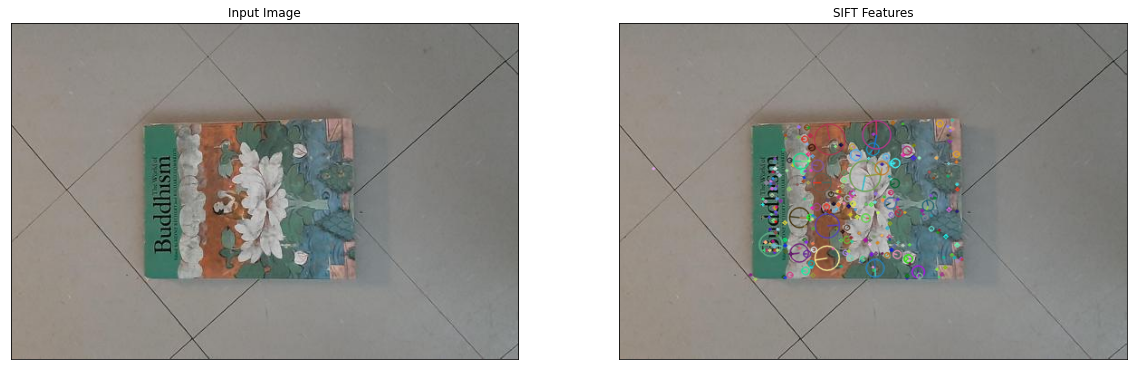

Num keypoints: 384


In [ ]:
# load image 
book_img = cv2.imread(path+"book.jpg")
# copy image
book_img_disp = book_img.copy()
# convert to RGB
book_img = cv2.cvtColor(book_img, cv2.COLOR_BGR2RGB)
book_img_disp = cv2.cvtColor(book_img_disp, cv2.COLOR_BGR2RGB)

# create a SIFT object
# cv.xfeatures2d.SIFT_create(	nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6	)
#                               nfeatures:	The number of best features to retain. The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
#                               nOctaveLayers:	The number of layers in each octave. 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.
#                               contrastThreshold:	The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector.
#                               edgeThreshold:	The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less features are filtered out (more features are retained).
#                               sigma:	The sigma of the Gaussian applied to the input image at the octave #0. If your image is captured with a weak camera with soft lenses, you might want to reduce the number

sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
# detect (image, mask), mask is used when you want to detect features from a specific part of image
keypoints = sift.detect(book_img, None)

# draw the keypoints
cv2.drawKeypoints(book_img, keypoints, book_img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(book_img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(book_img_disp)
plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT keypoints
print('Num keypoints: '+ str(len(keypoints)))

### 1.1.2 ~ 1.1.7

In [ ]:
####################
# FEATURE MATCHING #
####################

height, width = book_img.shape[0:2] # image size
scaling_factor = [0.2,0.5,0.8,1.25,2,5]
resize = []
for i in range(len(scaling_factor)):
  # Create a rotated, scaled duplicate
  # rotation marix around the center pixel, 0 degrees,scale of scaling_factor[i]
  # 2. Scale reference image using scaling factors of (0.2,0.5,0.8,1.25,2,5)
  # Can use function cv2.resize if we want to compare the whole picture after scaling
  M = cv2.getRotationMatrix2D((width/2,height/2),0,scaling_factor[i])

  # Apply the transformation matrix
  resize.append(cv2.warpAffine(book_img,M,(width,height)))

  # 3. Compute SIFT keypoints for the transformed images
  # Create a SIFT object
  sift = cv2.xfeatures2d.SIFT_create()

  # Compute the keypoints/descriptors
  keypoints1,descriptors1 = sift.detectAndCompute(book_img,None)
  keypoints2,descriptors2 = sift.detectAndCompute(resize[i],None)

  # 4. Match all keypoints of the reference image to the transformed images using a brute-force method
  # create BFMatcher object
  # normType: Different Types of Matcher. NORM_L1, NORM_L2, NORM_HAMMING, NORM_HAMMING2. Default: NORM_L2
  # crossCheck: If it is false, this is will be default BFMatcher behaviour when it finds the k nearest neighbors for each query descriptor. 
  #             If crossCheck==true, then the knnMatch() method with k=1 will only return pairs (i,j) such that for i-th query descriptor the 
  #             j-th descriptor in the matcher's collection is the nearest and vice versa, i.e. the BFMatcher will only return consistent pairs. 
  #             Such technique usually produces best results with minimal number of outliers when there are enough matches. This is alternative to the ratio test, used by D. Lowe in SIFT paper. Default: false  
  bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors.
  matches = bf.match(descriptors1,descriptors2) #query image, train image
  # DMatch.distance - Distance between descriptors. The lower, the better it is.
  # DMatch.trainIdx - Index of the descriptor in train descriptors
  # DMatch.queryIdx - Index of the descriptor in query descriptors
  # DMatch.imgIdx - Index of the train image.

  # 5. Sort matching keypoints according to the matching distance
  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  # 6. Display top ten matched keypoints for each pair of reference image and a transformed image
  # Draw all matches.
  match_img = cv2.drawMatches(book_img,keypoints1,resize[i],keypoints2, matches[:10], None, flags=2)

  # 7. Plot the matching distance for top 100 matched keypoints. Plot indices of keypoints on x-axis and corresponding matching distance on y-axis
  xAxis = []
  yAxis = []
  for j in range(100):
    xAxis.append(j)
    yAxis.append(matches[j].distance)

  # plotS
  plt.figure(figsize = (20, 20))
  plt.imshow(match_img)
  plt.title("Top 10 matched keypoints with scaling factor = %s" %scaling_factor[i]), plt.xticks([]), plt.yticks([])
  plt.figure(figsize = (20, 10))
  plt.plot(xAxis,yAxis,marker='o')
  plt.title('Matching distance for top 100 matched keypoints with scaling factor = %s' %scaling_factor[i])
  plt.xlabel('Indices of keypoints')
  plt.ylabel('Matching distance')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 1.1.8 Discuss the trend in the plotted results. What is the effect of increasing the scale on the matching distance? Reason the cause.

In all the graphs plotted, the matching distance increases with indices of keypoints because those values sorted. <br>When scaling factor is equal to 0.2, the matching distance ranges from 60 to 370. <br>When scaling factor is equal to 0.5, the matching distance ranges from 20 to 270. <br>When scaling factor is equal to 0.8, the matching distance ranges from 10 to 58. <br>When scaling factor is equal to 1.25, the matching distance ranges from 8 to 52. <br>When scaling factor is equal to 2, the matching distance ranges from 19 to 52. <br>When scaling factor is equal to 5, the matching distance ranges from 20 to 290. <br>A general trend is that when scaling factor increases, the range of distances becomes smaller, which means that more descriptors on the two pictures are similar. This is because more details are shown when scaling up, which is good for comparison. But up to a certain point, its range will become larger again, because the scaled up image is too big and only a small amount of distances are small, the others are very large. In other words, only a small amount of descriptors are similar, others are very unsimilar because the image is scaled too big, not so many descriptors can be compared. Scaling factor 1.25 shows the best result among those 5 factors.

## 1.2 Invariance Under Rotation

### 1.2.1 Compute SIFT keypoints for the reference image

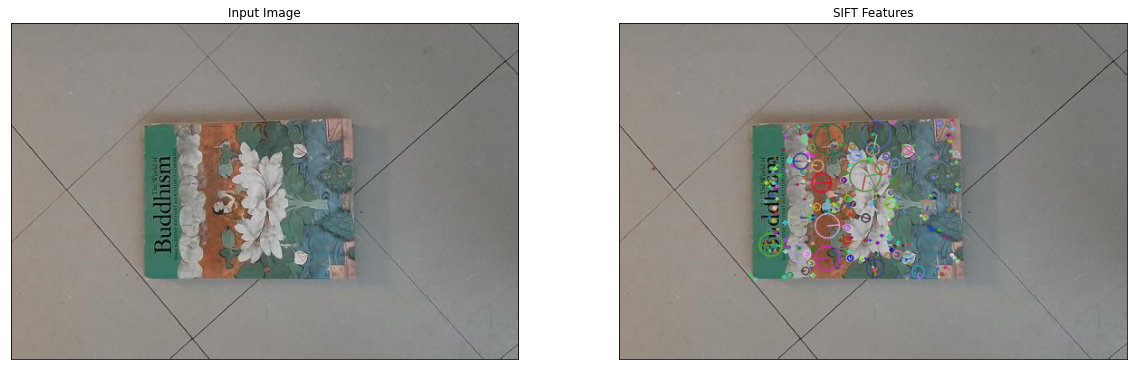

Num keypoints: 384


In [ ]:
# load image 
book_img = cv2.imread(path+"book.jpg")
# copy image
book_img_disp = book_img.copy()
# convert to RGB
book_img = cv2.cvtColor(book_img, cv2.COLOR_BGR2RGB)
book_img_disp = cv2.cvtColor(book_img_disp, cv2.COLOR_BGR2RGB)

# create a SIFT object
# cv.xfeatures2d.SIFT_create(	nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6	)
#                               nfeatures:	The number of best features to retain. The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
#                               nOctaveLayers:	The number of layers in each octave. 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.
#                               contrastThreshold:	The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector.
#                               edgeThreshold:	The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less features are filtered out (more features are retained).
#                               sigma:	The sigma of the Gaussian applied to the input image at the octave #0. If your image is captured with a weak camera with soft lenses, you might want to reduce the number

sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
# detect (image, mask), mask is used when you want to detect features from a specific part of image
keypoints = sift.detect(book_img, None)

# draw the keypoints
cv2.drawKeypoints(book_img, keypoints, book_img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(book_img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(book_img_disp)
plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT keypoints
print('Num keypoints: '+ str(len(keypoints)))

### 1.2.2 ~ 1.2.7

In [ ]:
####################
# FEATURE MATCHING #
####################

height, width = book_img.shape[0:2] # image size
angle = [10,30,90,150,170,180]
reshape = []
for i in range(len(angle)):
  # Create a rotated, scaled duplicate
  # rotation marix around the center pixel, angle[i] degrees,scale of 1
  # 2. Rotate reference image at the angle of (10, 30, 90, 150, 170, 180)
  M = cv2.getRotationMatrix2D((width/2,height/2),angle[i],1)

  # Apply the transformation matrix
  reshape.append(cv2.warpAffine(book_img,M,(width,height)))

  # 3. Compute SIFT keypoints for the transformed images
  # Create a SIFT object
  sift = cv2.xfeatures2d.SIFT_create()

  # Compute the keypoints/descriptors
  keypoints1,descriptors1 = sift.detectAndCompute(book_img,None)
  keypoints2,descriptors2 = sift.detectAndCompute(reshape[i],None)

  # 4. Match all keypoints of the reference image to the transformed images using a brute-force method
  # create BFMatcher object
  # normType: Different Types of Matcher. NORM_L1, NORM_L2, NORM_HAMMING, NORM_HAMMING2. Default: NORM_L2
  # crossCheck: If it is false, this is will be default BFMatcher behaviour when it finds the k nearest neighbors for each query descriptor. 
  #             If crossCheck==true, then the knnMatch() method with k=1 will only return pairs (i,j) such that for i-th query descriptor the 
  #             j-th descriptor in the matcher's collection is the nearest and vice versa, i.e. the BFMatcher will only return consistent pairs. 
  #             Such technique usually produces best results with minimal number of outliers when there are enough matches. This is alternative to the ratio test, used by D. Lowe in SIFT paper. Default: false  
  bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors.
  matches = bf.match(descriptors1,descriptors2) #query image, train image
  # DMatch.distance - Distance between descriptors. The lower, the better it is.
  # DMatch.trainIdx - Index of the descriptor in train descriptors
  # DMatch.queryIdx - Index of the descriptor in query descriptors
  # DMatch.imgIdx - Index of the train image.

  # 5. Sort matching keypoints according to the matching distance
  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  # 6. Display top ten matched keypoints for each pair of reference image and a transformed image
  # Draw all matches.
  match_img = cv2.drawMatches(book_img,keypoints1,reshape[i],keypoints2, matches[:10], None, flags=2)

  # 7. Plot the matching distance for top 100 matched keypoints. Plot indices of keypoints on x-axis and corresponding matching distance on y-axis
  xAxis = []
  yAxis = []
  for j in range(100):
    xAxis.append(j)
    yAxis.append(matches[j].distance)

  # plot
  plt.figure(figsize = (20, 20))
  plt.imshow(match_img)
  plt.title("Top 10 matched keypoints with angle = %s" %angle[i]), plt.xticks([]), plt.yticks([])
  plt.figure(figsize = (20, 10))
  plt.plot(xAxis,yAxis,marker='o')
  plt.title('Matching distance for top 100 matched keypoints with angle = %s' %angle[i])
  plt.xlabel('Indices of keypoints')
  plt.ylabel('Matching distance')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 1.2.8 Discuss the trend in the plotted results. What is the effect of increasing the angle of rotation on the matching distance? Reason the cause.

When rotating angle is equal to 10, the matching distance ranges from about 12 to 44. <br>When rotating angle is equal to 30, the matching distance ranges from about 5 to 48. <br>When rotating angle is equal to 90, the matching distance ranges from about 14 to 45. <br>When rotating angle is equal to 150, the matching distance ranges from about 11 to 45. <br>When rotating angle is equal to 170, the matching distance ranges from about 9 to 44. <br>When rotating angle is equal to 180, the matching distance equals to 0 at all keypoints. <br>For all the graphs above, we can see that they range from about 10 to about 45. However, the general trend is that when rotating angle increases from 0 to 90, more indices of keypoints will have a slightly higher matching distance. When rotating angle increases from 90 to 180, this number will decrease, which is almost the symmetrical situation about the 90 degree division. When the angle is 180, the two images are considered the same because all the matching distances are 0. As a result, we can deduce that 90 degree is a line of symmetry. The reason might be that the image will be considered to have more similarities if its shape or angle is closer to the original image. And we can deduce that 270 degree is the other line of symmetry. What is more, when we reach 360 degrees, all the matching distances will become 0 again.

# 2. Matching using SIFT - Book Reveal

## 2.1 Find SIFT keypoints in given input images

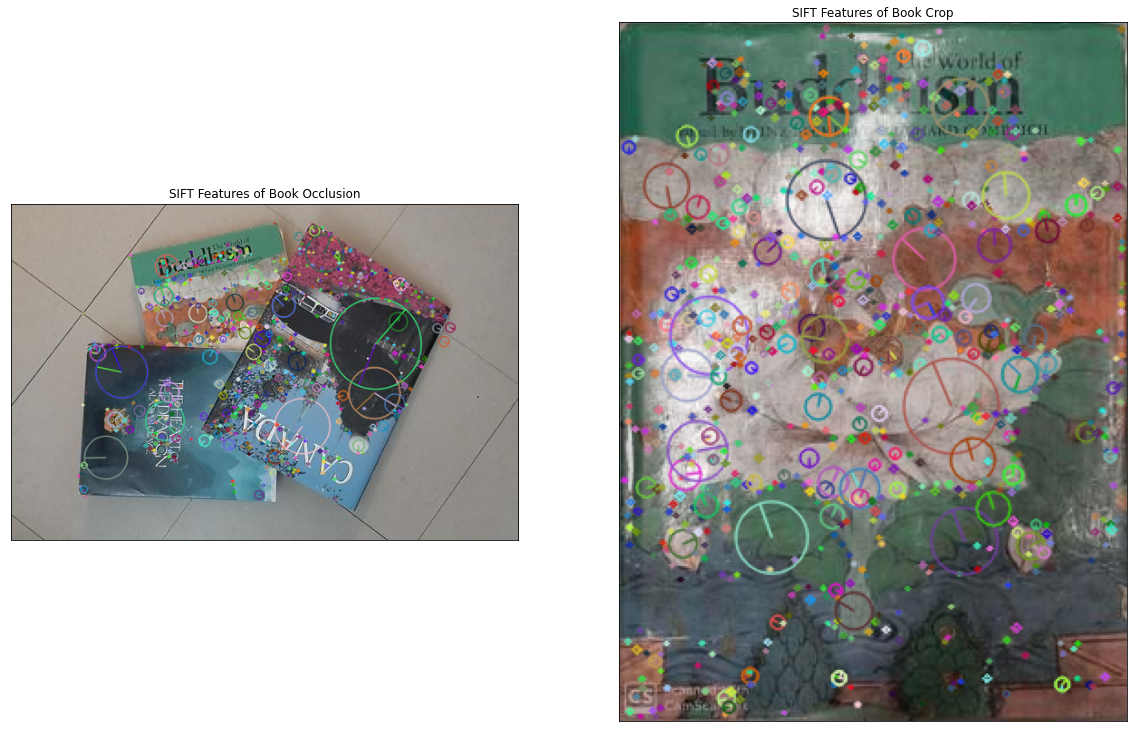

Num keypoints in book occlusion: 769
Num keypoints in book crop: 947


In [ ]:
# load image 
occlusion_img = cv2.imread(path+"book_occlusion.jpg")
crop_img = cv2.imread(path+"book_crop.jpg")
# copy image
occlusion_img_disp = occlusion_img.copy()
crop_img_disp = crop_img.copy()
# convert to RGB
occlusion_img = cv2.cvtColor(occlusion_img, cv2.COLOR_BGR2RGB)
occlusion_img_disp = cv2.cvtColor(occlusion_img_disp, cv2.COLOR_BGR2RGB)
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
crop_img_disp = cv2.cvtColor(crop_img_disp, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift_obj = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
# detect (image, mask), mask is used when you want to detect features from a specific part of image
# Compute the keypoints/descriptors
keypoints_occlusion,descriptors_occlusion = sift_obj.detectAndCompute(occlusion_img,None)
keypoints_crop,descriptors_crop = sift_obj.detectAndCompute(crop_img,None)

# draw the keypoints
cv2.drawKeypoints(occlusion_img, keypoints_occlusion, occlusion_img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(crop_img, keypoints_crop, crop_img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(occlusion_img_disp)
plt.title("SIFT Features of Book Occlusion"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(crop_img_disp)
plt.title("SIFT Features of Book Crop"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT keypoints
print('Num keypoints in book occlusion: '+ str(len(keypoints_occlusion)))
print('Num keypoints in book crop: '+ str(len(keypoints_crop)))

## 2.2 ~ 2.4

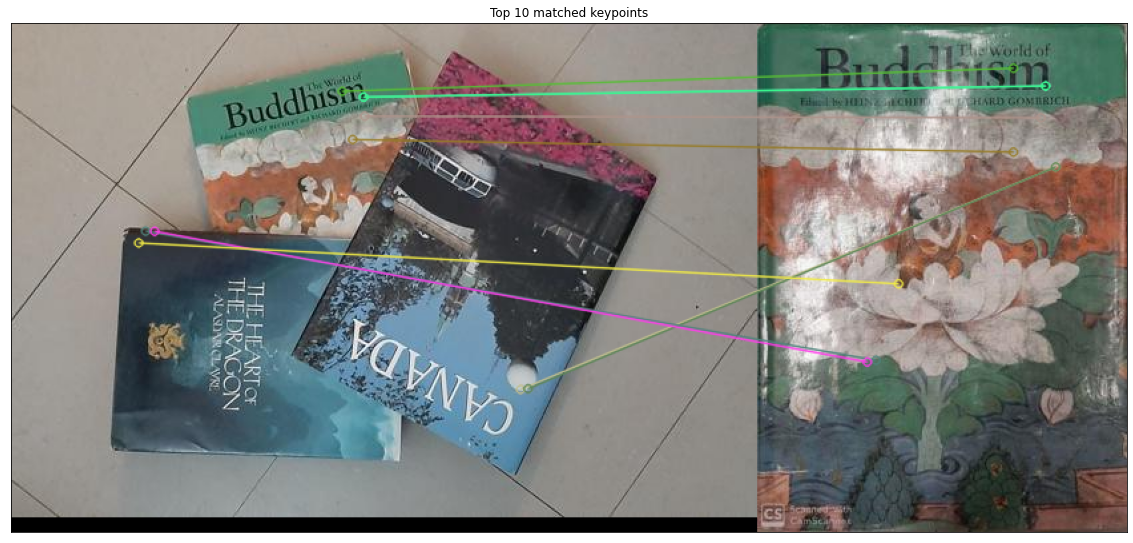

In [ ]:
bf_obj = cv2.BFMatcher()

# Match descriptors.
# 2. Match keypoints of reference image to the keypoints of the occluded image using brute-force method.
matches_obj = bf_obj.match(descriptors_occlusion,descriptors_crop) #query image, train image
# DMatch.distance - Distance between descriptors. The lower, the better it is.
# DMatch.trainIdx - Index of the descriptor in train descriptors
# DMatch.queryIdx - Index of the descriptor in query descriptors
# DMatch.imgIdx - Index of the train image.

# 3. Sort matching keypoints according to the matching distance.
# Sort them in the order of their distance.
matches_obj = sorted(matches_obj, key = lambda x:x.distance)

# 4. Display top ten matching keypoints.
# Draw first 10 matches.
match_dis = cv2.drawMatches(occlusion_img,keypoints_occlusion,crop_img,keypoints_crop, matches_obj[:10], None, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(match_dis)
plt.title("Top 10 matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.5 ~ 2.6

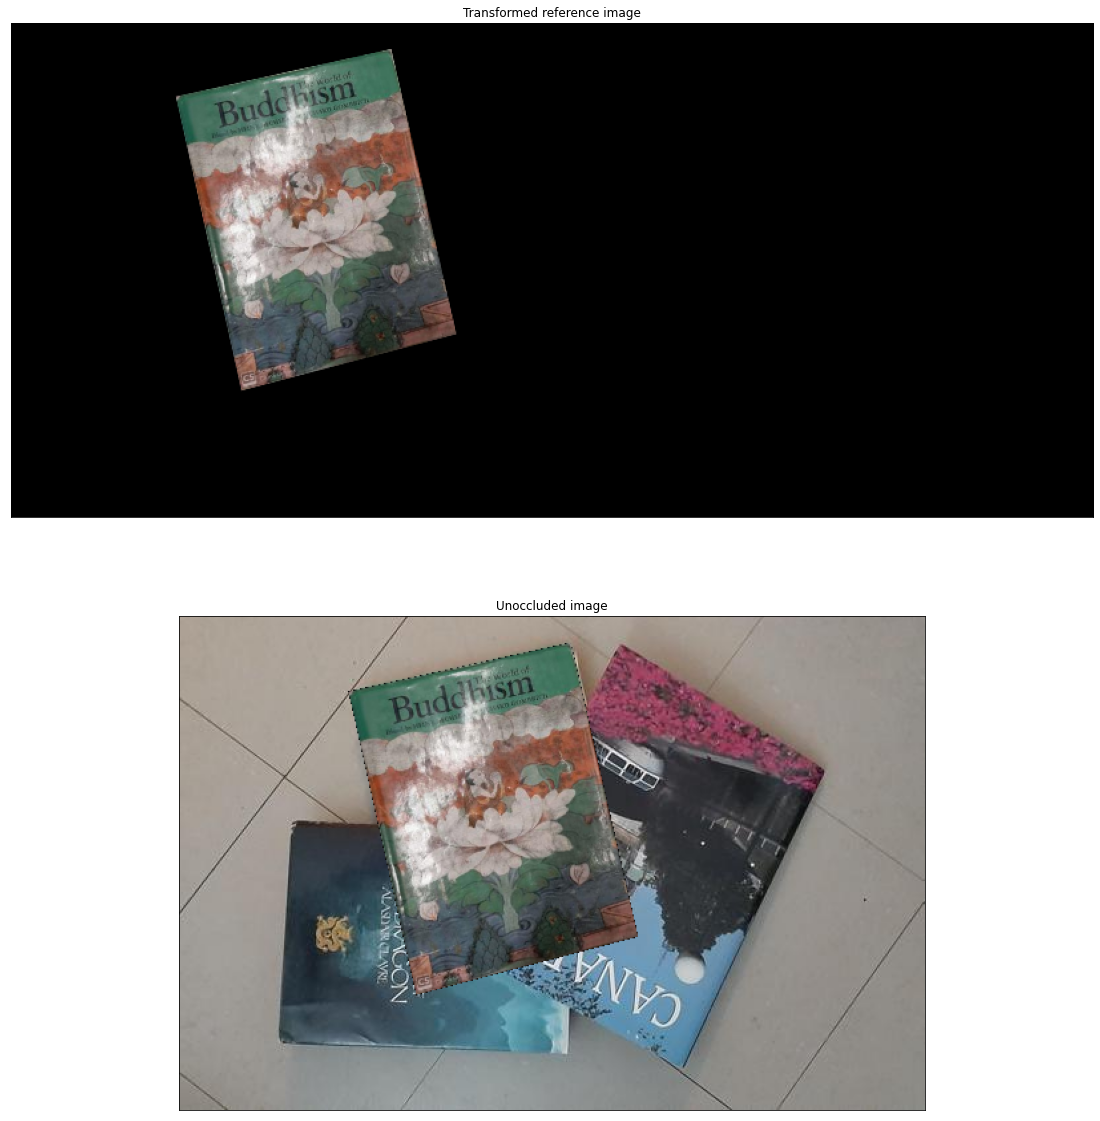

In [ ]:
#5. Compute a homography to align the images using RANSAC method and apply the transformation on the reference image.
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches_obj):
  if m.distance < 150:
    GoodMatches.append((m.queryIdx, m.trainIdx))

mp_occlusion = np.float32([keypoints_occlusion[i].pt for (i, __) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (__, i) in GoodMatches])

# find homography and wrap image accordingly

# https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
H, __ = cv2.findHomography(mp_crop, mp_occlusion, cv2.RANSAC, 4)

# 6. Paste transformed reference image on the occluded view to generate unoccluded view as shown in Figure 2(c)
# https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=warpaffine#warpperspective
# cv2.warpPerspective(src, M, dsize, dst, flags, borderMode, borderValue) → dst
# Parameters:	
#           src – input image.
#           dst – output image that has the size dsize and the same type as src .
#           M – 3\times 3 transformation matrix.
#           dsize – size of the output image.
#           flags – combination of interpolation methods (INTER_LINEAR or INTER_NEAREST) and the optional flag WARP_INVERSE_MAP, that sets M as the inverse transformation ( dst --> src ).
#           borderMode – pixel extrapolation method (BORDER_CONSTANT or BORDER_REPLICATE).
#           borderValue – value used in case of a constant border; by default, it equals 0.

wimg = cv2.warpPerspective(crop_img, H, (crop_img.shape[1]+occlusion_img.shape[1],crop_img.shape[0]))

# We get the book's region in wimg image, only get those places where they are not in black color, which is the book
# Since wimg is a 3D graph, we need to have three loops
# Then we replace the book's region in occlusion image with the wimg image
for i in range(wimg.shape[0]):
  for j in range(wimg.shape[1]):
    for k in range(wimg.shape[2]):
      if wimg[i, j, k] > 0:
        occlusion_img[i,j,k] = wimg[i,j,k]

plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(wimg)
plt.title("Transformed reference image"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(occlusion_img)
plt.title("Unoccluded image"), plt.xticks([]), plt.yticks([])
plt.show()

# 3. Face Detection

## 3.1 Eigenface Representation

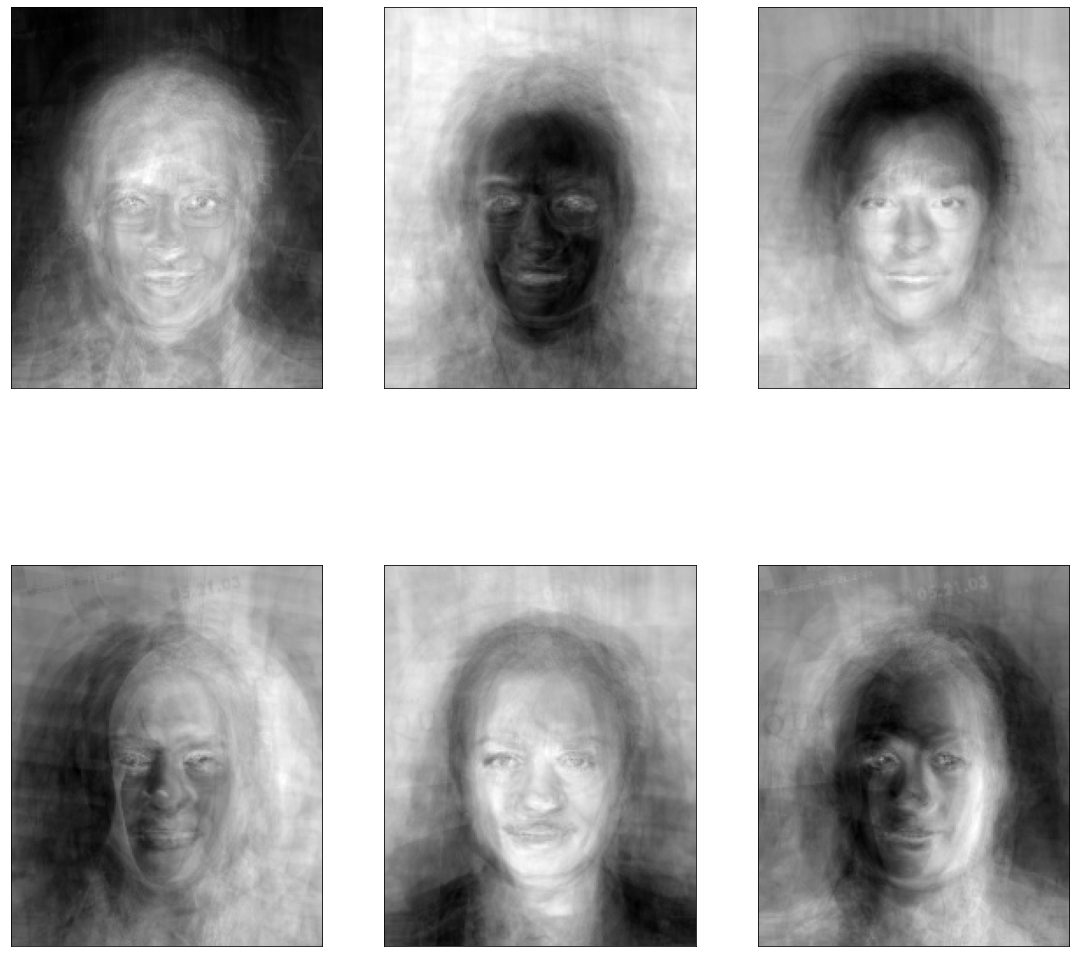

In [ ]:
import os
import random
random.seed(10)
path_celebA = path + 'celebA_subset/'
files = os.listdir(path_celebA)

my_files = [] # this variable will store names of your randomly selected 100 files
for i in random.sample(range(0, 1000), 100):
  my_files.append(files[i])

def PCA(file):
  FaceMat = [] # this variable will store 100 conversions of image to 1-D
  for j in range(len(file)):
    image = cv2.imread(path_celebA + file[j], 0) # for each image, read it in grayscale
    # reshape into one column
    image = image.reshape(-1,1)
    FaceMat.append(image)

  FaceMat = np.array(FaceMat) # shape: (100, 38804, 1)
  # mean subtraction
  # np.array will automatically change the string to some blocks of several value
  # in this case will be 100 blocks of values each with dimension 38804 rows and 1 column
  FaceMat = FaceMat.reshape(FaceMat.shape[0], FaceMat.shape[1]) # reshape(row,column) shape: (100, 38804)
  FaceMat = np.mat(FaceMat).T # shape: (38804, 100)
  # perform zero mean
  avgMat = np.mean(FaceMat,1) # average the FaceMat
  stdMat = np.std(FaceMat,1) # standard deviation of FaceMat
  # data: X, (X - X.mean()) / X.std()
  diffMat = (FaceMat-avgMat)/stdMat # shape: (38804, 100)

  # calculate the eigenvalues and eigenvectors of covariance matrix using snapshot method
  eigVals,eigVects = np.linalg.eig(np.mat(diffMat.T*diffMat)) 
  # eigVals shape: (100,) eigVects shape: (100, 100)
  # sort the eigenvalues in descending order, argsort() returns the indices that would sort an array
  # if a = x.argsort(), x[a] will get the sorted array
  eigValsSorted = eigVals.argsort()[::-1]
  # get the sorted array for both eigenvalues and eigenvectors
  sorted_eigVals = eigVals[eigValsSorted]
  sorted_eigVects = eigVects[:,eigValsSorted]
  eigenFace = np.dot(diffMat,sorted_eigVects) # shape: (38804, 100)
  return eigenFace, avgMat, sorted_eigVals, sorted_eigVects

plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
# plot the gallery of the top 6 most significative eigenfaces
eigenface,averageMat,sortedEigvalues,sortedEigVects= PCA(my_files)
for l in range(6):
  plt.subplot(2, 3, l + 1)
  # size of an image is 218(height/number of rows) x 178(width/number of columns)
  plt.imshow(eigenface[:,l].reshape(218,178), cmap=plt.cm.gray)
  plt.xticks(())
  plt.yticks(())
plt.show()

## 3.2. Face Detection

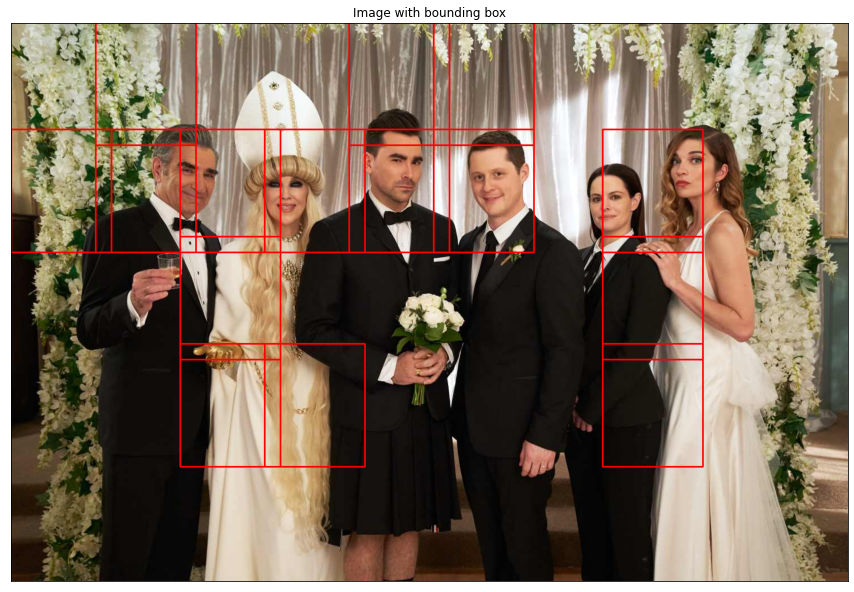

In [ ]:
# This is the method to calculate pricipal components K
def eigValPct(sorted_eigVals, percentage):
  pct = np.sum(sorted_eigVals)*percentage
  temp = 0
  num = 0
  for var in sorted_eigVals:
    temp += var
    num += 1
    if temp >= pct:
      return num

# Compute K components
def components(K,new_face_mat,mat_difference):
  w = np.dot(new_face_mat.T,mat_difference) # the projected face, K coefficients, shape: (18,1)
  w = np.array(w)
  sum_w = np.zeros((38804,1))
  for index in range(K):
    sum_w += w[index][0] * new_face_mat[:,index]
  return sum_w

def sliding_window(image_dis,image_gray,eigenFace,average_mat,K,thres):
    step_horizontal=150;
    step_vertical=190;
    window_size = (178, 218)
    eigface_mat = eigenFace[:,:K]
    # range(start, stop[, step])
    # x is horizontal and y is vertical
    for y in range(0, image_gray.shape[0]-231, step_vertical): # 231 = 991 - (991-218)/150 * 190
      for x in range(0, image_gray.shape[1]-286, step_horizontal): # 286 = 1486 - (1486-178)/150 * 150
        # image axis is visited as [row, column]
        window = image_gray[y:y+window_size[1], x:x+window_size[0]]
        window = window.reshape(-1,1)
        diff_mat = window-average_mat # shape: (38804,1)
        face_sum = components(K,eigface_mat,diff_mat) # shape: (38804,1)
        window = diff_mat-face_sum
        matrix_norm = np.linalg.norm(window)
        if matrix_norm > thres:
          continue
        else:
          # rectangle parameters: image, top left corner(TLC), bottom right corner(BRC), RGB color, thickness
          # TLC: (horizontal min,vertical min) and BRC:(horizontal max,vertical max)
          cv2.rectangle(image_dis,(x,y),(x+window_size[0],y+window_size[1]),(255,0,0),2)
    return image_dis

coeffi = eigValPct(sortedEigvalues, 0.8) # Value of K

group_img = cv2.imread(path + "schitt's_creek_group_photo.jpeg")
group_img_RGB = cv2.cvtColor(group_img, cv2.COLOR_BGR2RGB)
group_img_gray = cv2.cvtColor(group_img, cv2.COLOR_BGR2GRAY)
group_img_RGB_copy = group_img_RGB.copy()
thresh = 7000000000
group_img_dis = sliding_window(group_img_RGB_copy,group_img_gray,eigenface,averageMat,coeffi,thresh)

# plot images
plt.figure(figsize = (15, 15))
plt.imshow(group_img_dis)
plt.title("Image with bounding box"), plt.xticks([]), plt.yticks([])
plt.show()

This method does detect their faces but it is not working very well. This implementation has some drawbacks. In order to be able to minus mean matrix in the previous dataset, the size of the window has to be the same size as before, which is (218,178). This makes the window very large and makes it easier to have false positives. If we want to make sure that those faces are in the middle of a window, we have to slide the window slowly, which is moving with small steps. However, this will not give us the desired results since false positives number increases and duplicate windows are shown on the same face. If we increase the threshold used for detecting faces, more windows will appear, including detected faces and false postives. The threshold is set to 7,000,000,000 to get the image above. There are 9 false postives in total. However, some faces are detected more than once.

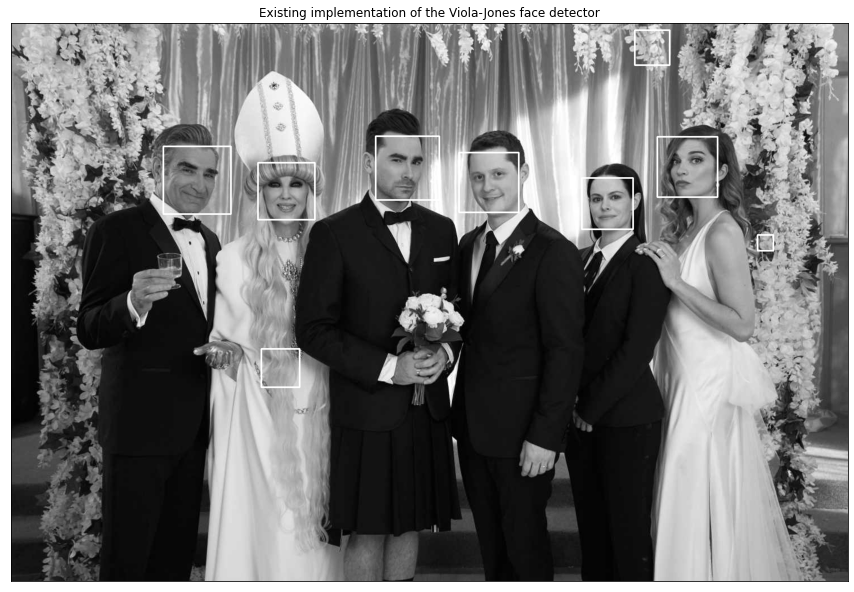

In [13]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

group_img = cv2.imread(path + "schitt's_creek_group_photo.jpeg")
group_img_gray = cv2.cvtColor(group_img, cv2.COLOR_BGR2GRAY)

# detecMutliScale
#   Params: image – Matrix of the type CV_8U containing an image where objects are detected.
#           scaleFactor (1.1) – Parameter specifying how much the image size is reduced at each image scale.
#           minNeighbors (3) – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
#           minSize (0,0) – Minimum possible object size. Objects smaller than that are ignored.
#           maxSize (0,0) – Maximum possible object size. Objects larger than that are ignored.

faces = face_cascade.detectMultiScale(group_img_gray, 1.1, 6)

for (x,y,w,h) in faces:
    group_img_gray = cv2.rectangle(group_img_gray,(x,y),(x+w,y+h),(255,0,0),2)

plt.figure(figsize = (15,15))
plt.imshow(group_img_gray, cmap="gray")
plt.title("Existing implementation of the Viola-Jones face detector"), plt.xticks([]), plt.yticks([])
plt.show()

Using Viola-Jones face detector, all six faces are detected and no duplicate windows on the same face. There are only 3 false positives shown, which is less than 9 in the previous method. When the training set image size is large while the faces in the input image is small, PCA does not work. When the faces in the input image is very small and close, PCA may not have enough information to detect them. But Viola-Jones detector can scale them to get more information. Viola-Hones detector will take into consideration of light intensity and light origin, while PCA will not consider this factor, so PCA may not work in this situation as well.